In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display
from sklearn import manifold, datasets

# Append base directory
import os,sys,inspect
rootname = "chernysheva-tmaze-analysis-2020"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

from scipy.stats import mannwhitneyu, binom
rstest_twosided = lambda x, y : mannwhitneyu(x, y, alternative='two-sided')

# User libraries
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.metric.metric_non_uniform import MetricCalculatorNonUniform
from mesostat.utils.arrays import numpy_merge_dimensions
from mesostat.utils.pandas_helper import outer_product_df

from src.lib.data_db import BehaviouralNeuronalDatabase
import src.lib.plots_lib as plots_lib
from src.lib.plots_pca  import PCAPlots
from src.lib.metric_wrapper import metric_by_interval, metric_by_phase
from src.lib.extra_metrics import num_non_zero_std, num_sample

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/chernysheva-tmaze-analysis-2020


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
params['root_path_dff'] = '/media/alyosha/Data/TE_data/mariadata/dff/'
params['root_path_deconv'] = '/media/alyosha/Data/TE_data/mariadata/deconv/'
# params['root_path_dff'] = '/media/aleksejs/DataHDD/work/data/maria/dff/'
# params['root_path_deconv'] = '/media/aleksejs/DataHDD/work/data/maria/deconv/'

In [3]:
dataDB = BehaviouralNeuronalDatabase(params)

In [4]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read DFF Data:', max=27)

IntProgress(value=0, description='Read DECONV Data:', max=27)

In [5]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


# 1. Clustering

Main idea:
* Select and cluster datapoints
* Color clustering by modality


Analysis Strategies:
1. Select 1 interval, color by modality $LR\otimes CM$
2. Select modality, color by interval

Dynamics Strategies:
1. Static-noob-1: One point per timestep. Bad because biased towards trials with more timesteps, slower transients
    * Nothing to be seen on TSNE
2. Static-noob-2: Mean value per trial. Balanced. Probably averages out important info
    * Nothing to be seen on TSNE
3. Dynamic-slow-legendre. Multiplex channels and legendre temporal basis. Good for stretch hypothesis
4. Dynamic-noob-1: Window-sweep time, multiplex onto channels. Bias+too-many-dimensions
5. Dynamic-noob-2: As above + preprocess dim.reduction. Bias

In [7]:
def fit_color_data(ax, X, labels, perplexity):
    method = manifold.TSNE(n_components=2, init='pca', perplexity=perplexity)
#     method = manifold.SpectralEmbedding(n_components=2, n_neighbors=10)
    Y = method.fit_transform(X)
    
    for label in sorted(set(labels)):
        idxs = labels == label
        ax.plot(Y[idxs, 0], Y[idxs, 1], 'o', label=label)
    ax.legend()

## 1.1. Interval -> Modalities

No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
m060 [(74, 88), (59, 88), (5, 88), (15, 88)]
No behaviour found for {'performance': 'Mistake', 'direction': 'R', 'session': 'm061_20190517'} ; skipping
m061 [(36, 46), (38, 46), (9, 46), (7, 46)]
m065 [(89, 83), (92, 83), (33, 83), (24, 83)]
m066 [(65, 47), (86, 47), (21, 47), (16, 47)]
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm067_20200203'} ; skipping
m067 [(77, 49), (77, 49), (13, 49), (30, 49)]
m068 [(93, 28), (82, 28), (33, 28), (30, 28)]


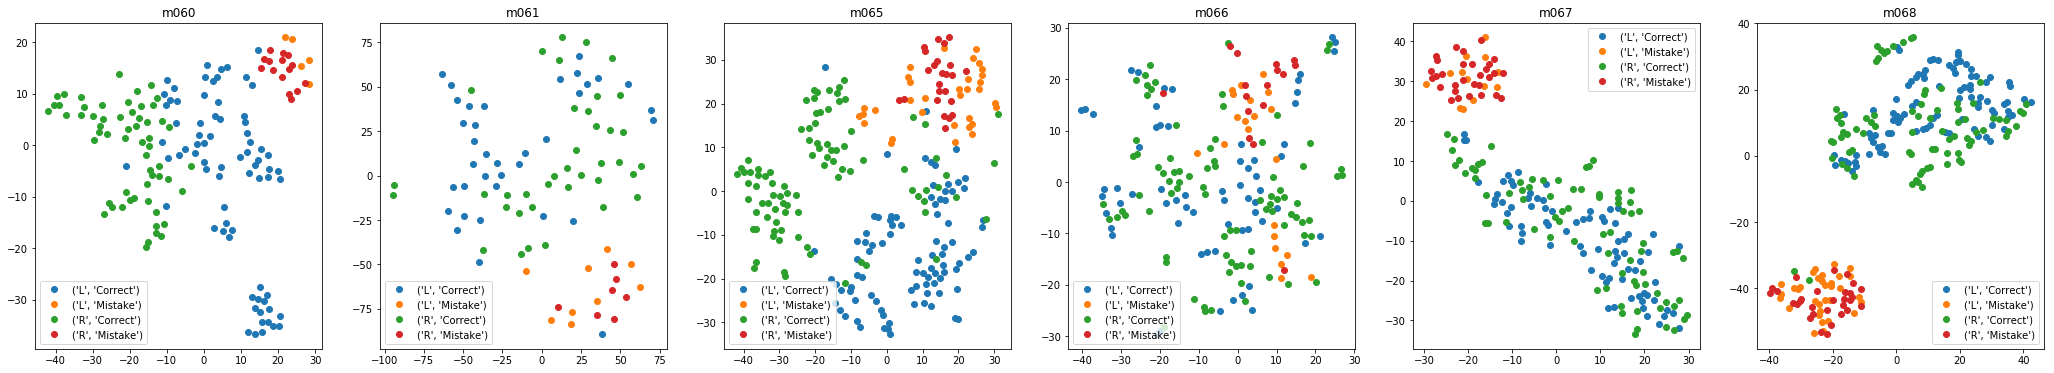

In [8]:
def tsne_interval_by_behaviour(datatype, interval, perplexity):
    mc = MetricCalculatorNonUniform(serial=True)

    fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(6*len(dataDB.mice), 6))
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        labelsBigLst = []
        dataBigLst = []
        for performance in ['Correct', 'Mistake']:
            for direction in ['L', 'R']:
                queryDict = {'datatype' : datatype, 'mousename' : mousename, 'performance' : performance, 'direction' : direction}

                dataLst = dataDB.get_data_from_interval(interval, interval+1, queryDict)

#                 mc.set_data(dataLst)
#                 dataArr = mc.metric3D("temporal_basis", "rp", metricSettings={"basisOrder": 5})
#                 dataArr = numpy_merge_dimensions(dataArr, 1, 3)

#                 dataArr = np.hstack(dataLst).T  # concatenate trials and timepoints
                dataArr = np.array([np.mean(d, axis=1) for d in dataLst if d.shape[1] > 0])
                dataBigLst += [dataArr]
                labelsBigLst += [str((direction, performance))]*len(dataArr)

        print(mousename, [d.shape for d in dataBigLst])
        dataBigArr = np.vstack(dataBigLst)

        fit_color_data(ax[iMouse], dataBigArr, np.array(labelsBigLst), perplexity)
        ax[iMouse].set_title(mousename)

    plt.savefig("tsne_interval_"+str(interval)+".svg")
    plt.show()
    
tsne_interval_by_behaviour('deconv', 10, perplexity=10)

## 1.2. Modality -> Intervals

Doing mouse m060
[(74, 88), (74, 88), (74, 88)]
Doing mouse m061
[(36, 46), (36, 46), (36, 46)]
Doing mouse m065
[(89, 83), (89, 83), (89, 83)]
Doing mouse m066
[(65, 47), (65, 47), (65, 47)]
Doing mouse m067
[(77, 49), (77, 49), (77, 49)]
Doing mouse m068
[(93, 28), (93, 28), (93, 28)]


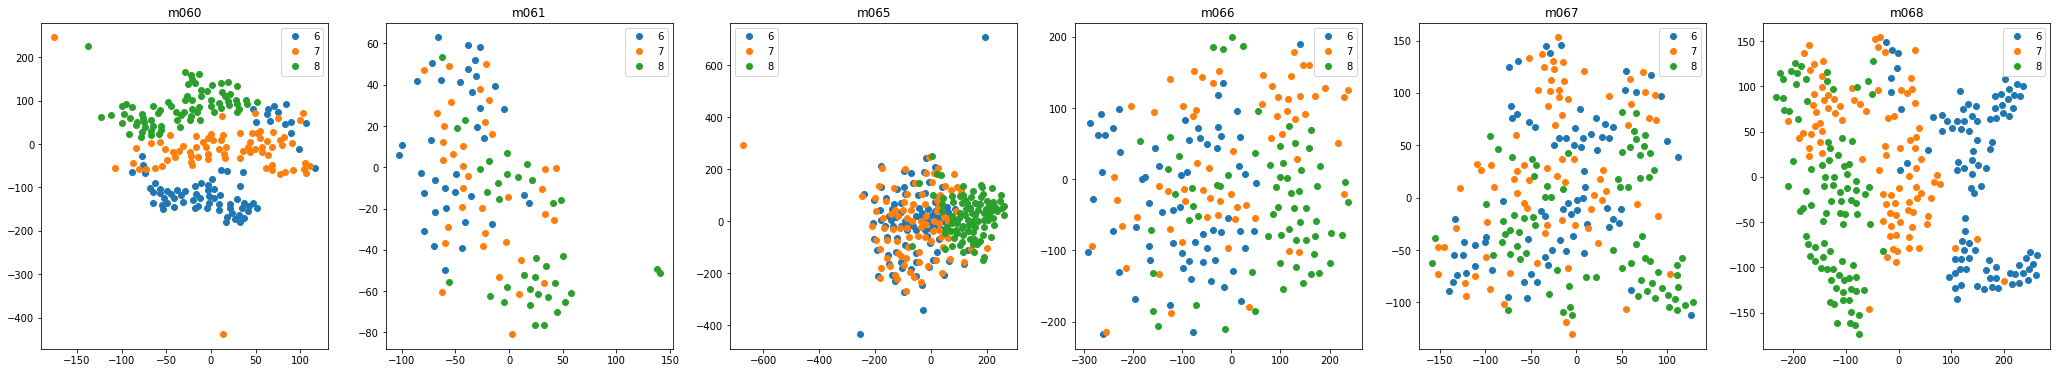

In [9]:
def tsne_behaviour_by_interval(queryDict, perplexity):
    mc = MetricCalculatorNonUniform(serial=True)

    fig, ax = plt.subplots(ncols=len(dataDB.mice), figsize=(6*len(dataDB.mice), 6))
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Doing mouse", mousename)
        queryDictMouse = {**queryDict, **{'mousename' : mousename}}

        labelsBigLst = []
        dataBigLst = []

        for interval in range(5, 8):

            dataLst = dataDB.get_data_from_interval(interval, interval+1, queryDictMouse)

    #         mc.set_data(dataLst)
    #         dataArr = mc.metric3D("temporal_basis", "rp", metricSettings={"basisOrder": 5})
    #         dataArr = numpy_merge_dimensions(dataArr, 1, 3)

    #         dataArr = np.hstack(dataLst).T  # concatenate trials and timepoints
            dataArr = np.array([np.mean(d, axis=1) for d in dataLst])
            dataBigLst += [dataArr]
            labelsBigLst += [str(interval+1)]*len(dataArr)

        print([d.shape for d in dataBigLst])
        dataBigArr = np.vstack(dataBigLst)

        fit_color_data(ax[iMouse], dataBigArr, np.array(labelsBigLst), perplexity)
        ax[iMouse].set_title(mousename)

    plt.savefig("tsne_modality_"+queryDict['performance']+'_'+queryDict['direction']+".svg")
    plt.show()

queryDict = {'datatype' : 'raw', 'performance' : 'Correct', 'direction' : 'L'}
tsne_behaviour_by_interval(queryDict, perplexity=20)

# 5. Trajectory via PCA

Main Point:
* Select 1 interval
* compute 2D PCA
* plot trajectories by trial
* color by modality ($LR\otimes CM$)

Dynamics Strategy:
0. Naive-0: Plot indivitual PCA components as function of time
1. Naive-1: Exact PCA coordinates
    * Problem: that is not a trajectory, just blob that oscillates around zero
2. Adept-1: Add intertia by time-accumulation
3. Adept-2: Add intertia by gaussian-filtering
    
aaa
* **TODO**: Average over trials for 1 mouse, only 1 session
* **TODO**: How is average and cumulative possible simultaneously
* **TODO**: Add curve distance as function of timestep, shuffle test

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Doing mouse: m060
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
--Doing strategy: {'cropStrategy': 'stretch', 'trialStrategy': None, 'accStrategy': None}
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
--Doing strategy: {'cropStrategy': 'stretch', 'trialStrategy': None, 'accStrategy': 'cumulative'}
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
--Doing strategy: {'cropStrategy': 'stretch', 'trialStrategy': None, 'accStrategy': 'gaussfilter'}
No behaviour found for {'performance': 'Mistake', 'direction': 'L', 'session': 'm060_20190606'} ; skipping
--Doing strategy: {'cropStrategy': 'stretch', 'trialS

--Doing strategy: {'cropStrategy': 'stretch', 'trialStrategy': None, 'accStrategy': 'gaussfilter'}
--Doing strategy: {'cropStrategy': 'stretch', 'trialStrategy': 'concat', 'accStrategy': None}
--Doing strategy: {'cropStrategy': 'stretch', 'trialStrategy': 'concat', 'accStrategy': 'cumulative'}
--Doing strategy: {'cropStrategy': 'stretch', 'trialStrategy': 'concat', 'accStrategy': 'gaussfilter'}
--Doing strategy: {'cropStrategy': 'stretch', 'trialStrategy': 'avg', 'accStrategy': None}
--Doing strategy: {'cropStrategy': 'stretch', 'trialStrategy': 'avg', 'accStrategy': 'cumulative'}
--Doing strategy: {'cropStrategy': 'stretch', 'trialStrategy': 'avg', 'accStrategy': 'gaussfilter'}
--Doing strategy: {'cropStrategy': 'cropmin', 'trialStrategy': None, 'accStrategy': None}
--Doing strategy: {'cropStrategy': 'cropmin', 'trialStrategy': None, 'accStrategy': 'cumulative'}
--Doing strategy: {'cropStrategy': 'cropmin', 'trialStrategy': None, 'accStrategy': 'gaussfilter'}
--Doing strategy: {'cropS

--Doing strategy: {'cropStrategy': 'cropmin', 'trialStrategy': None, 'accStrategy': None}
--Doing strategy: {'cropStrategy': 'cropmin', 'trialStrategy': None, 'accStrategy': 'cumulative'}
--Doing strategy: {'cropStrategy': 'cropmin', 'trialStrategy': None, 'accStrategy': 'gaussfilter'}
--Doing strategy: {'cropStrategy': 'cropmin', 'trialStrategy': 'concat', 'accStrategy': None}
--Doing strategy: {'cropStrategy': 'cropmin', 'trialStrategy': 'concat', 'accStrategy': 'cumulative'}
--Doing strategy: {'cropStrategy': 'cropmin', 'trialStrategy': 'concat', 'accStrategy': 'gaussfilter'}
--Doing strategy: {'cropStrategy': 'cropmin', 'trialStrategy': 'avg', 'accStrategy': None}
--Doing strategy: {'cropStrategy': 'cropmin', 'trialStrategy': 'avg', 'accStrategy': 'cumulative'}
--Doing strategy: {'cropStrategy': 'cropmin', 'trialStrategy': 'avg', 'accStrategy': 'gaussfilter'}


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


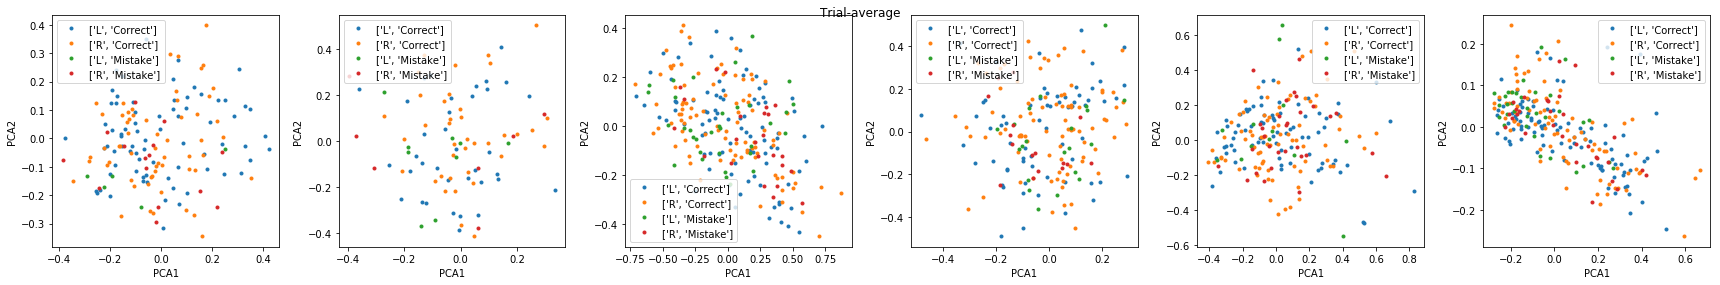

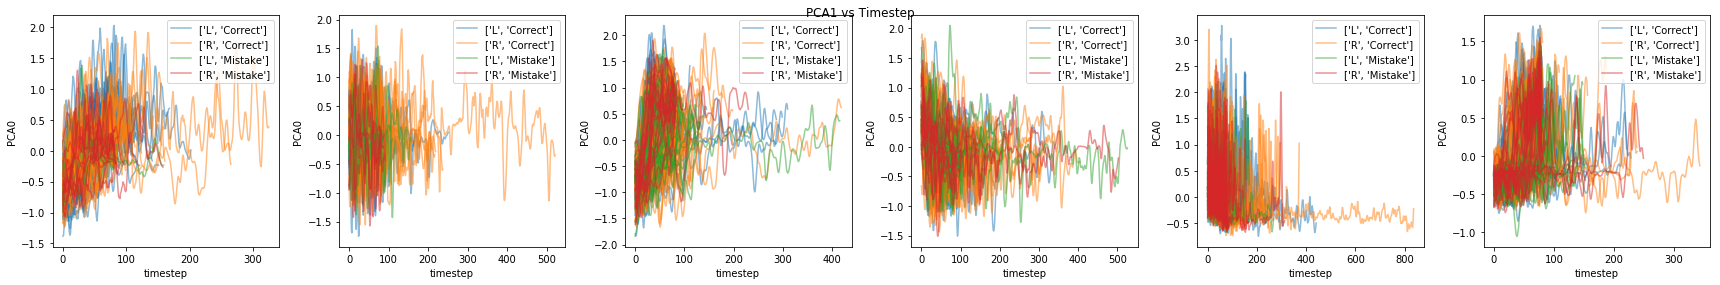

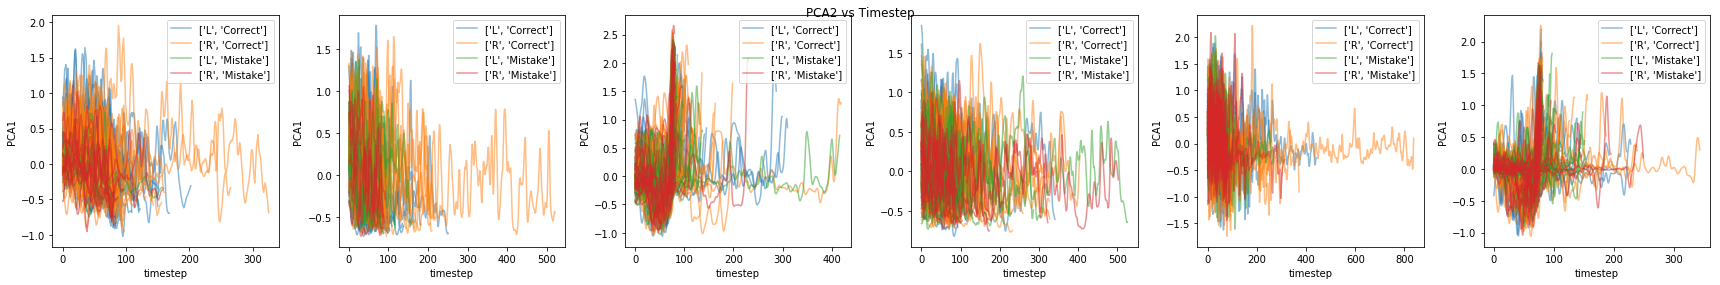

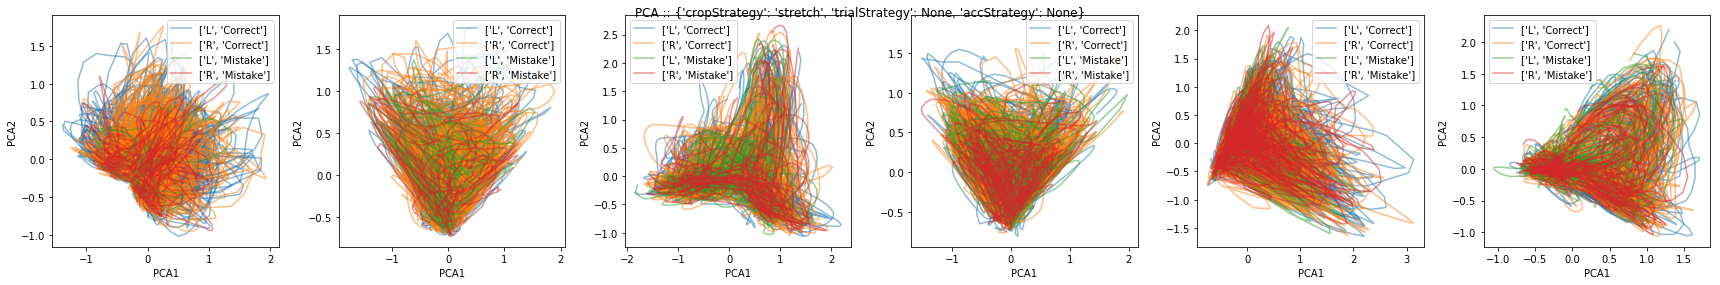

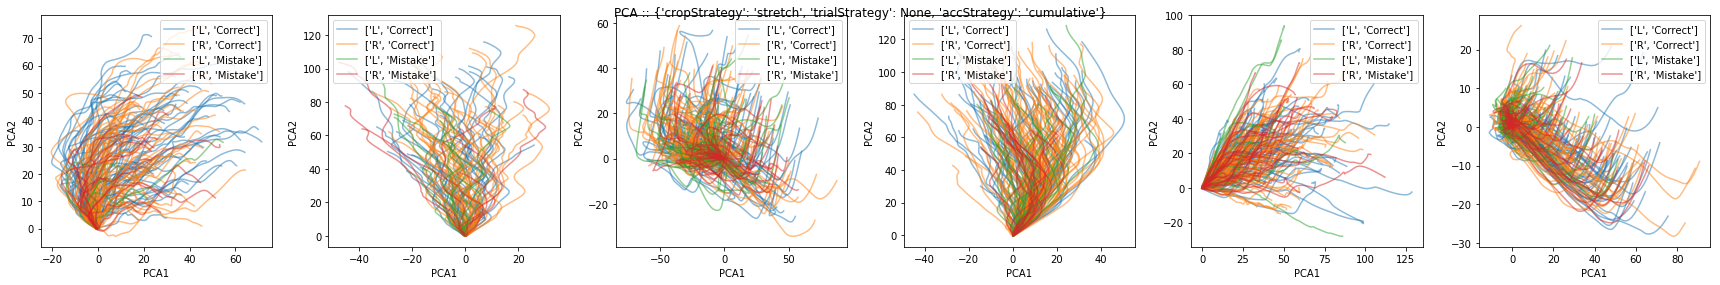

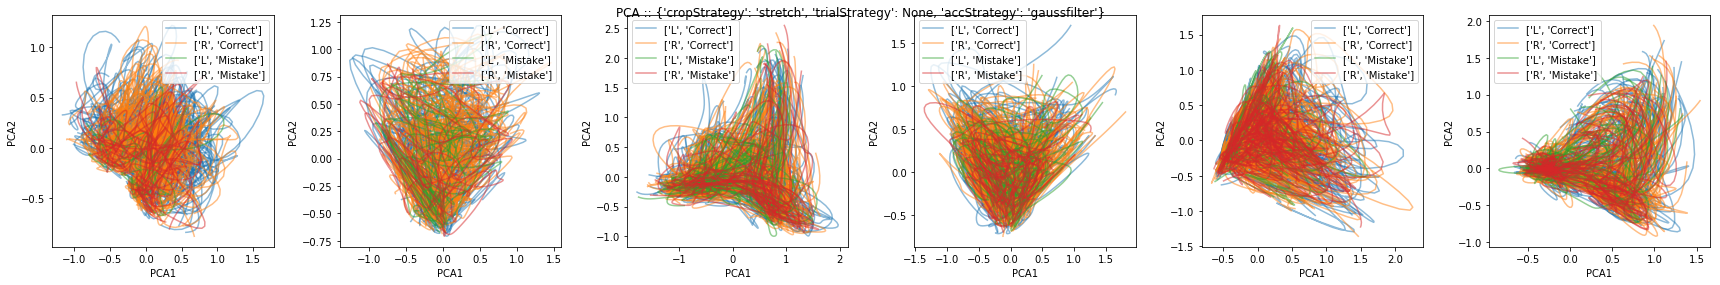

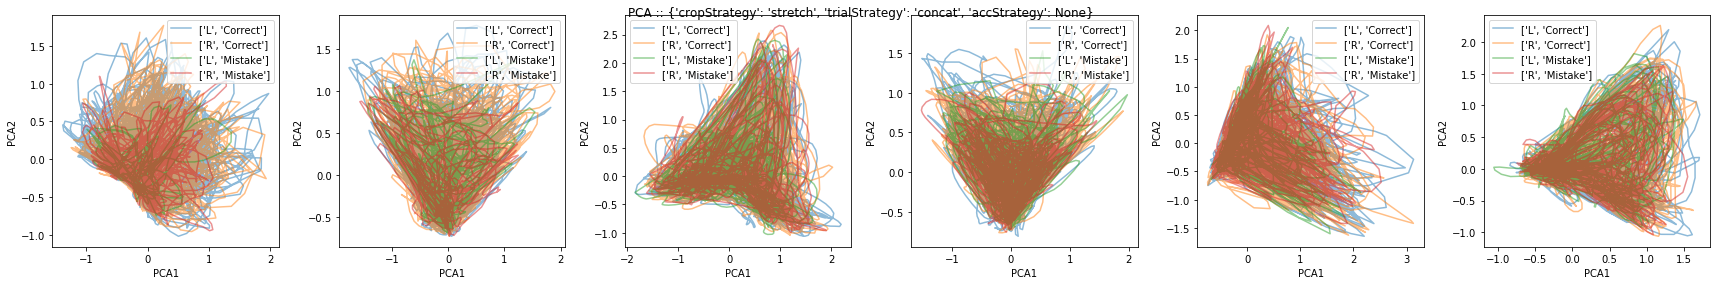

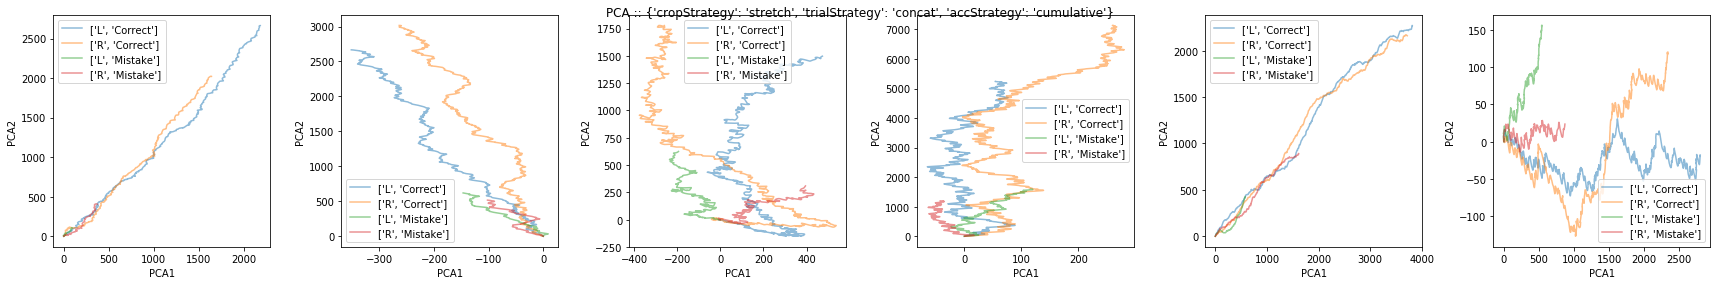

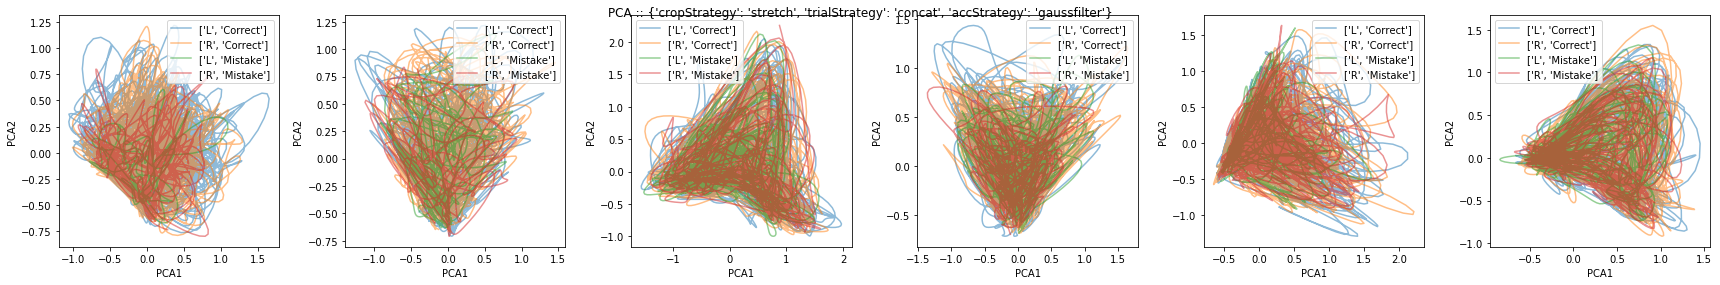

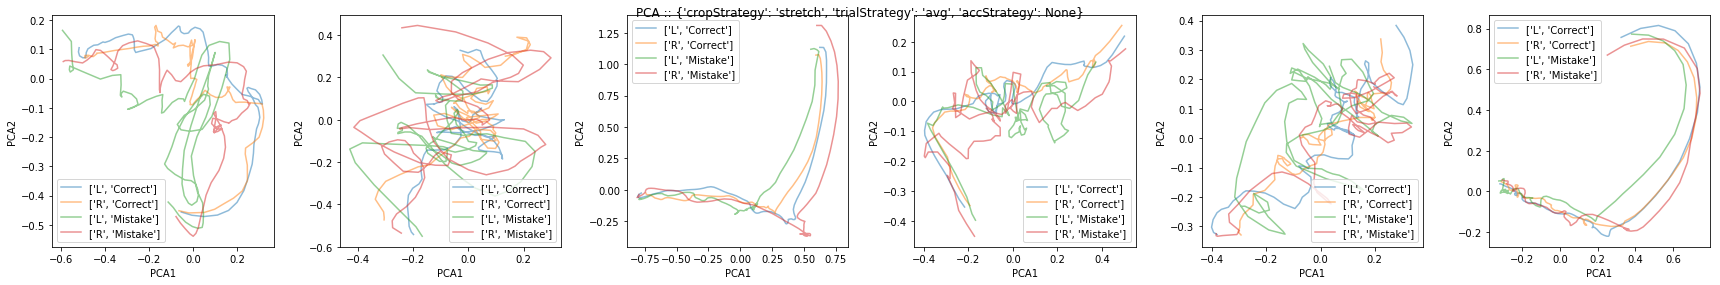

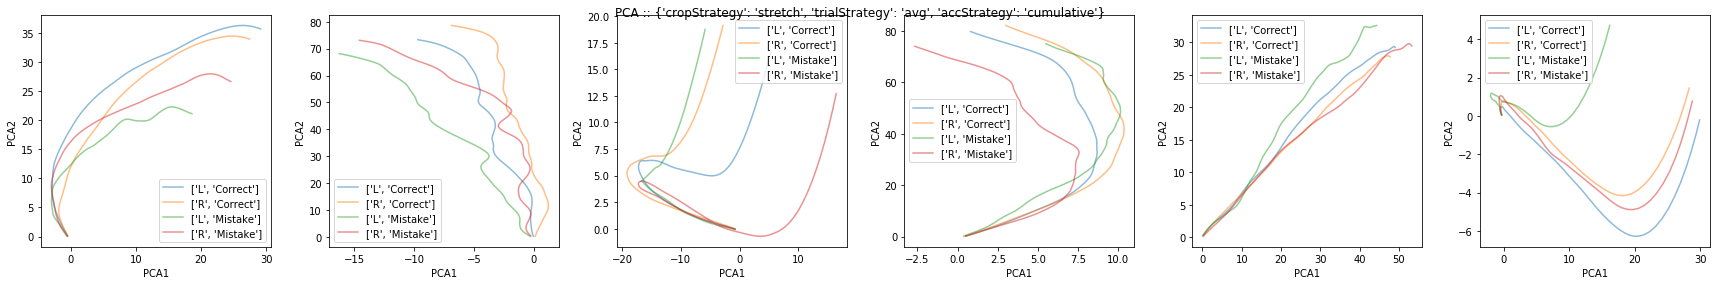

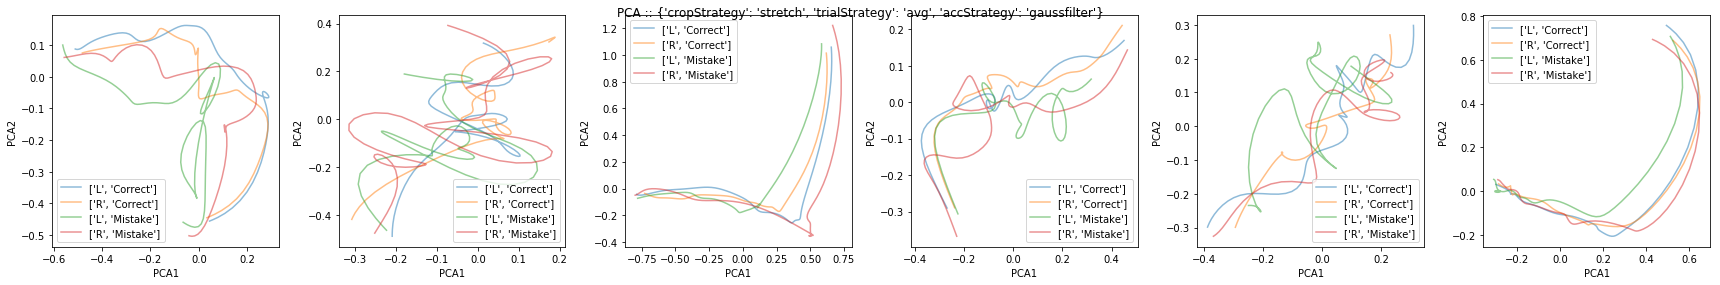

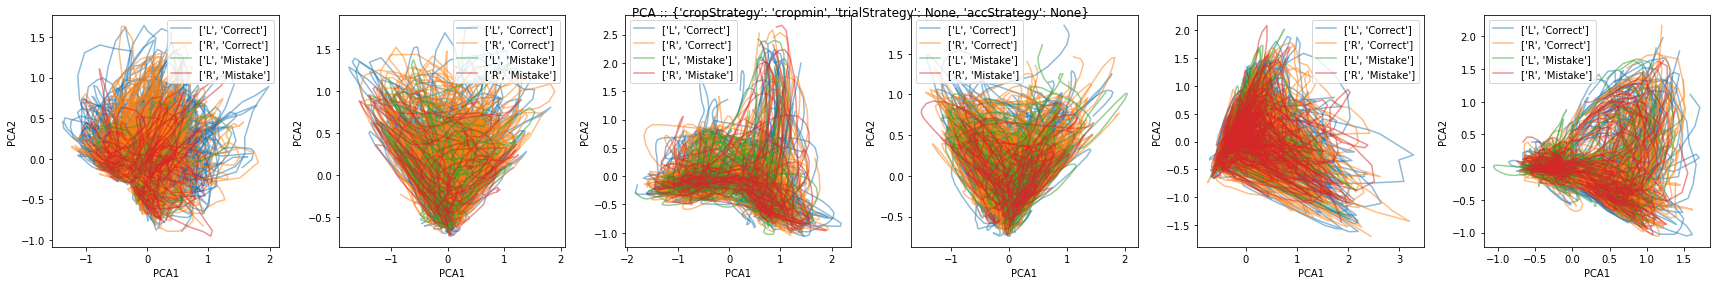

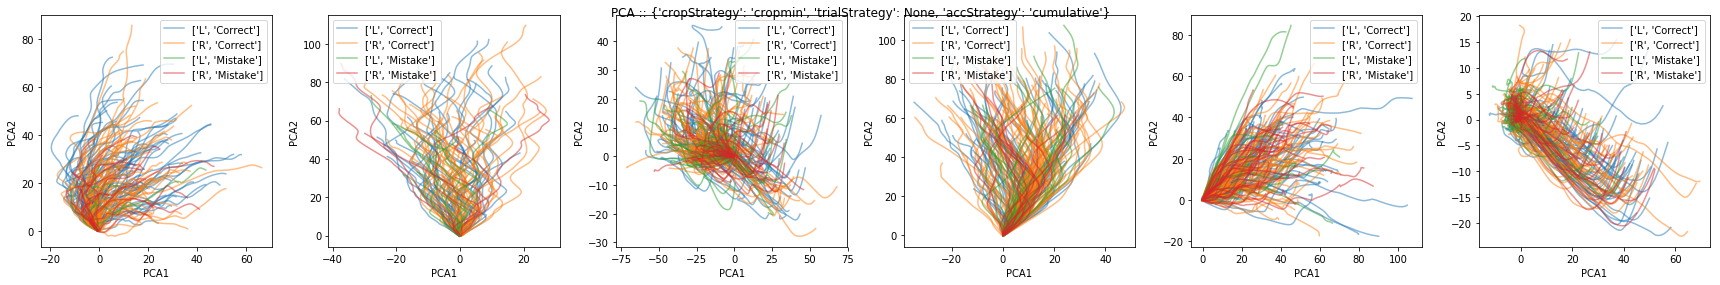

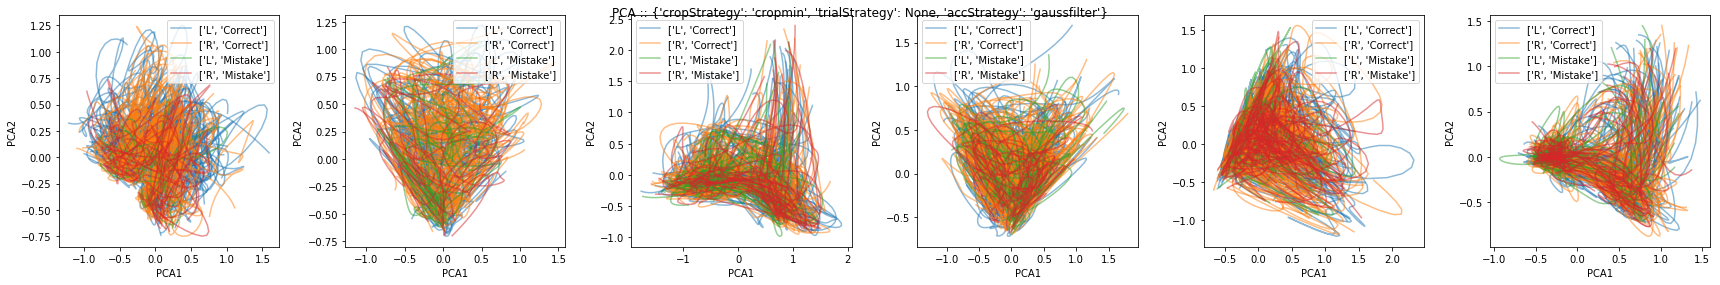

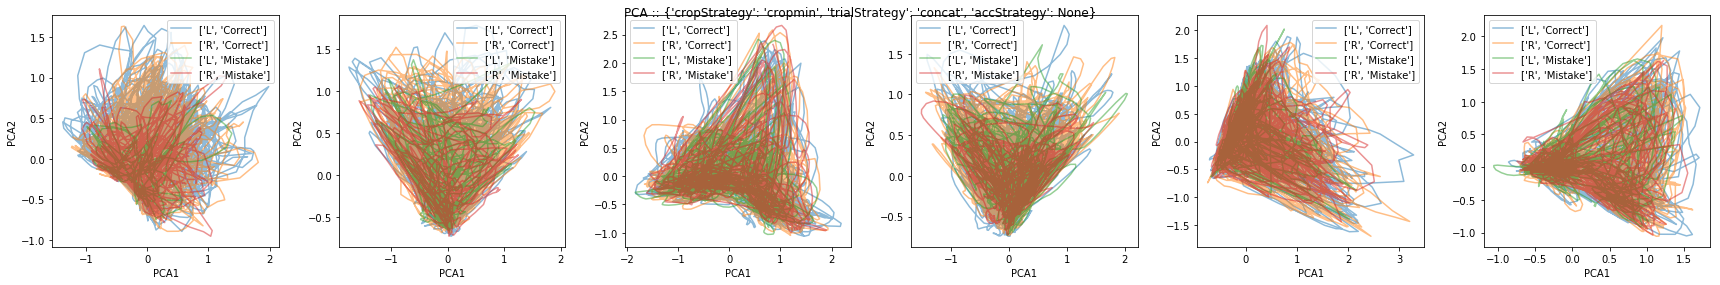

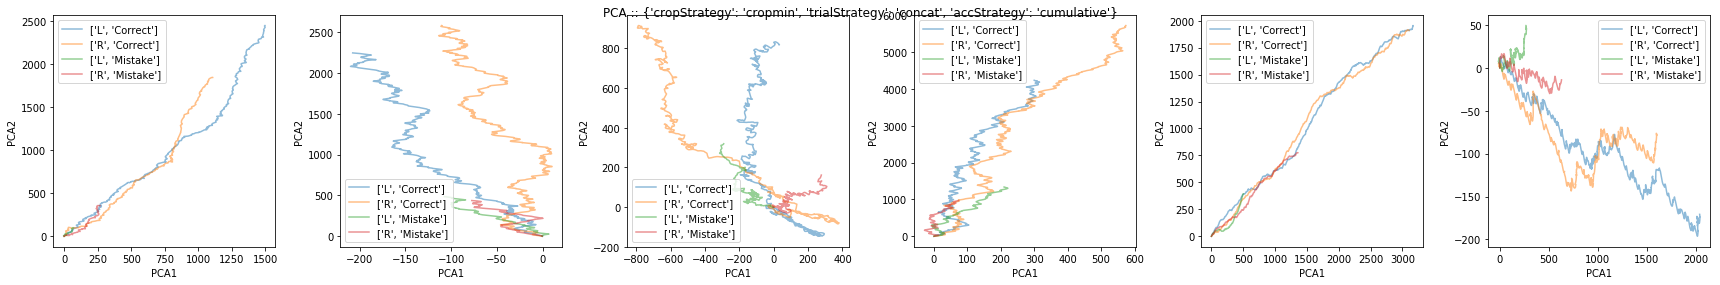

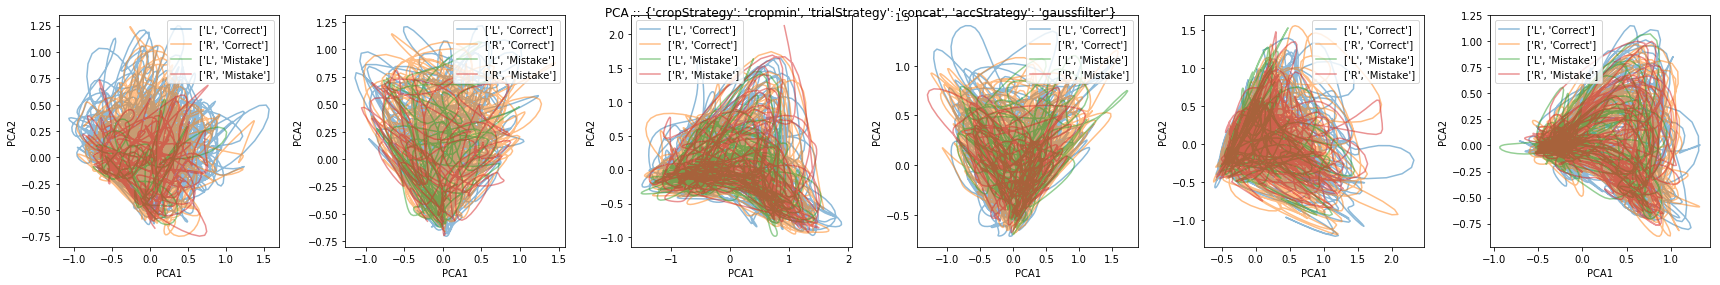

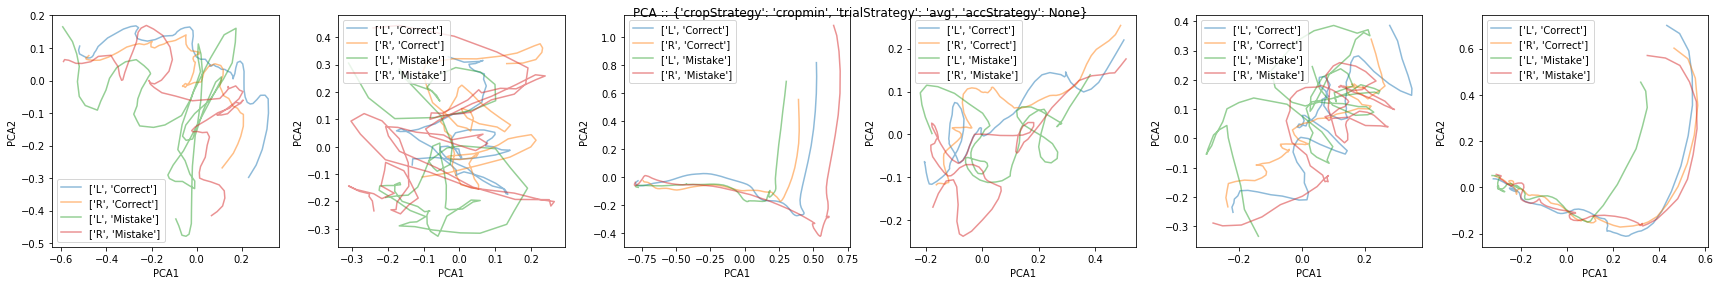

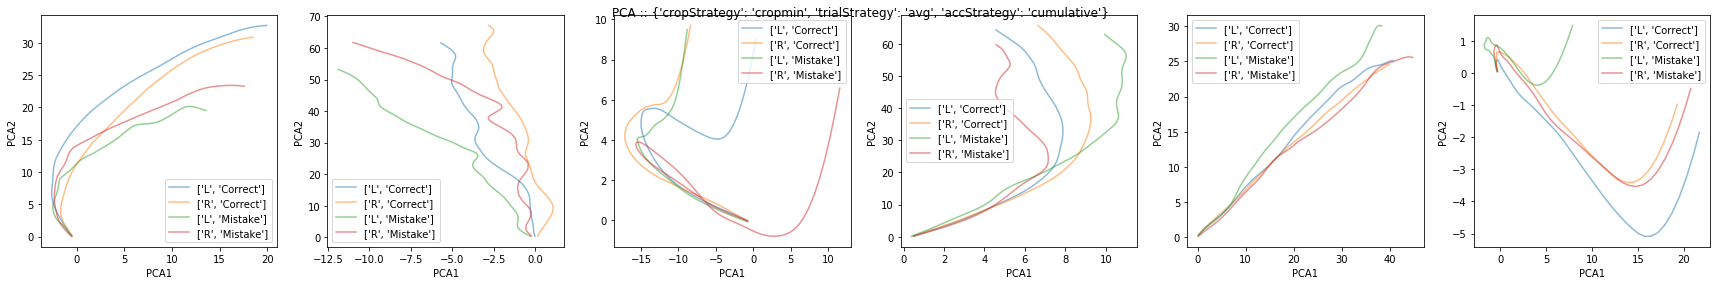

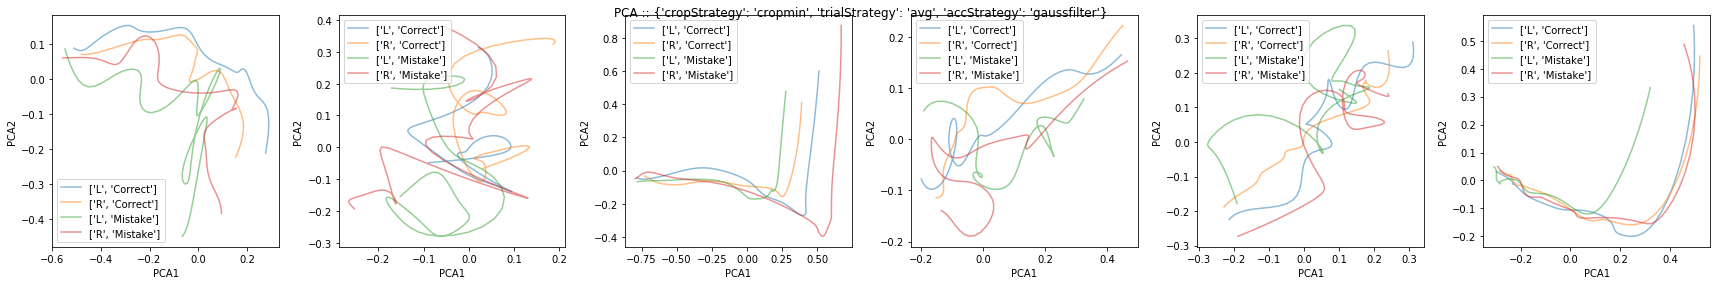

In [8]:
def pca_plots_wrapper(datatype, selector, paramDict):
    # Create all possible parameter combinations
    # Exclude trial-averaging when no crop strategy employed as it makes no sense to average trials of different length
    paramProdDF = outer_product_df(paramDict)
    badrows = paramProdDF[(paramProdDF['trialStrategy'] == 'avg') & (paramProdDF['cropStrategy'].isnull())]
    paramProdDF = paramProdDF.drop(badrows.index)
    paramProdDF = paramProdDF.reset_index(drop=True)

    def makefigure(nrows, ncols, title):
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows), tight_layout=True)
        fig.suptitle(title)
        return fig, ax

    figAvg, axAvg = makefigure(1, len(dataDB.mice), "Trial-average")
    figTime1, axTime1 = makefigure(1, len(dataDB.mice), "PCA1 vs Timestep")
    figTime2, axTime2 = makefigure(1, len(dataDB.mice), "PCA2 vs Timestep")
    figsPCA = [makefigure(1, len(dataDB.mice), "TMP") for i in range(len(paramProdDF))]
#     figsDist = [makefigure(1, len(dataDB.mice), "TMP") for i in range(len(paramProdDF))]

    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print("Doing mouse:", mousename)
        pp = PCAPlots(dataDB, selector, {'datatype' : datatype, 'mousename' : mousename})
        pp.set_stretch_timesteps(100)
        pp.plot_time_avg_scatter(axAvg[iMouse])
        pp.plot_pca_vs_time(axTime1[iMouse], 0)
        pp.plot_pca_vs_time(axTime2[iMouse], 1)

        for idx, row in paramProdDF.iterrows():
            print("--Doing strategy:", dict(row))
        
            # PCA
            fig, ax = figsPCA[idx]
            if iMouse == 0:
                fig.suptitle("PCA :: " + str(dict(row)))

            pp.plot_pca(ax[iMouse], dict(row))
                
                
#             # DIST
#             fig, ax = figsDist[idx]
#             if iMouse == 0:
#                 fig.suptitle("Dist :: " + str(dict(row)))

#             pp.plot_distances(ax[iMouse], dict(row))

    plt.show()

paramDict = {
    "cropStrategy" :["stretch", "cropmin"], #[None, "cropmin", "stretch"],
    "trialStrategy" : [None, "concat", "avg"],
    "accStrategy" : [None, "cumulative", "gaussfilter"]
}
    
pca_plots_wrapper('deconv', {"interval" : 7}, paramDict)
# pca_plots_wrapper('deconv', {"phase" : "Maintenance"}, paramDict)

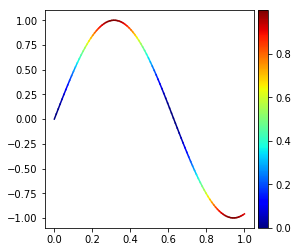

In [23]:
x = np.linspace(0, 1, 100)
y = np.sin(5*x)
z = x

fig, ax = plt.subplots(figsize=(4,4))
plots_lib.plot_coloured_1D(ax, x, y, y**2)
plt.show()